In [ ]:
## 1
library(dplyr)
library(tidyr)
library(readr)
library(readr)
library(purrr)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
folder_path <- "TCMA"
file_list <- list.files(folder_path, full.names = TRUE)

In [ ]:
result <- map_df(file_list, function(f) {
  dat <- read_tsv(f, locale = locale(encoding = "UTF-16LE"), show_col_types = FALSE)
  n_samples <- n_distinct(dat$Sample)         
  
  tibble(
    file = str_remove(basename(f), "\\.txt$"), 
    sample_count = n_samples
  )
})

print(result)


# A tibble: 36 × 2
   file                             sample_count
   <chr>                                   <int>
 1 Acute Myeloid Leukemia                      5
 2 Biliary Tract Cancer                       12
 3 Bladder Cancer                             19
 4 Bone Cancer                                50
 5 Brain Glioblastoma Multiforme              28
 6 Brain Lower Grade Glioma                   16
 7 Breast Cancer                             199
 8 Cervical Squamous Cell Carcinoma           14
 9 Chronic Lymphocytic Leukemia               66
10 Chronic Myeloid Disorders                  19
# ℹ 26 more rows


In [ ]:

all_data <- data.frame()

for (file in file_list) {
  temp <- read_tsv(file, locale = locale(encoding = "UTF-16LE"), show_col_types = FALSE)

  temp <- temp[, 1:2]

  temp <- distinct(temp) 

  all_data <- bind_rows(all_data, temp)
}

all_data <- distinct(all_data)

all_data[, 2] <- gsub("MT-", "", all_data[, 2])

In [ ]:

all_data <- all_data[all_data[, 2] != "N/A", ]

all_data <- na.omit(all_data)

In [ ]:
all_data=read.table("TCMA_cancer_mutation_gene.csv",sep=",",quote="",header=T)
sample_count=read.csv('TCMA_cancer_sample_counts.csv',sep=",",quote="",header=T)

In [ ]:
sample_count <- sample_count %>%
  mutate(Cancer_Type_label = paste0(Cancer_Type, " (n=", sample_count, ")"))
all_data1 <- merge(all_data,sample_count[,c(1,3)],by.x=1,by.y=1)

In [27]:
all_data=all_data1[,c(3,2)]

In [ ]:
genes <- unique(all_data[, 2])

samples <- unique(all_data[, 1])

binary_matrix <- matrix(0, nrow = length(samples), ncol = length(genes),
                        dimnames = list(samples, genes))


In [ ]:

for (i in 1:nrow(all_data)) {
  sample <- all_data[i, 1]
  gene <- all_data[i, 2]
  binary_matrix[sample,gene] <- 1
}

In [ ]:
library(ComplexHeatmap)
library(circlize) 

Loading required package: grid



ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualizati

In [ ]:

gene_counts <- colSums(binary_matrix)

gene_order <- order(-gene_counts, names(gene_counts))
binary_matrix_ordered <- binary_matrix[, gene_order]

cancer_gene_counts <- rowSums(binary_matrix_ordered)

cancer_order <- order(-cancer_gene_counts, names(cancer_gene_counts))
binary_matrix_ordered <- binary_matrix_ordered[cancer_order, ]

binary_matrix_ordered_factor <- apply(binary_matrix_ordered, c(1, 2), as.character)

In [ ]:
gene_counts_df <- data.frame(
  Gene = names(gene_counts),  
  Count = gene_counts        
)

gene_counts_df <- gene_counts_df[order(gene_counts_df$Count, decreasing = TRUE), ]

write.csv(gene_counts_df, file = "TCMA_cancer_gene_counts_sorted.csv", row.names = FALSE)

In [ ]:
cancer_gene_counts_df <- data.frame(
  Gene = names(cancer_gene_counts), 
  Count = cancer_gene_counts         
)

cancer_gene_counts_df <- cancer_gene_counts_df[order(cancer_gene_counts_df$Count, decreasing = TRUE), ]

write.csv(cancer_gene_counts_df, file = "data/TCMA_cancer_cancer_counts_sorted.csv", row.names = FALSE)

In [ ]:
nature_colors_fresh <- c(
  "0" = "#F5F5F5",  
  "1" = "#00ACC1"   
)

In [ ]:
p = Heatmap(
  binary_matrix_ordered_factor,
  name = "Status",
  col = nature_colors_fresh,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  show_row_names = TRUE,
  show_column_names = TRUE,
  row_names_side = "left",
  column_names_side = "bottom",
  column_names_rot = 45,
  row_names_gp = gpar(fontsize = 22),  
  column_names_gp = gpar(fontsize = 22, just = "right", rot = 45),
  heatmap_legend_param = list(
    at = c("0", "1"),
    labels = c("Absent", "Present"),
    title = "Status",
    title_gp = gpar(fontsize = 22),
    labels_gp = gpar(fontsize = 22)
  ),
  border = TRUE,
  column_title_gp = gpar(fontsize = 20),
  row_title_gp = gpar(fontsize = 20),
  width = unit(45, "cm"),  
  height = unit(30, "cm"),
    cell_fun = function(j, i, x, y, width, height, fill) {
    grid.rect(x, y, width = unit(1, "mm"), height = unit(1, "mm"), 
              gp = gpar(fill = fill, col = NA))  
  }
)

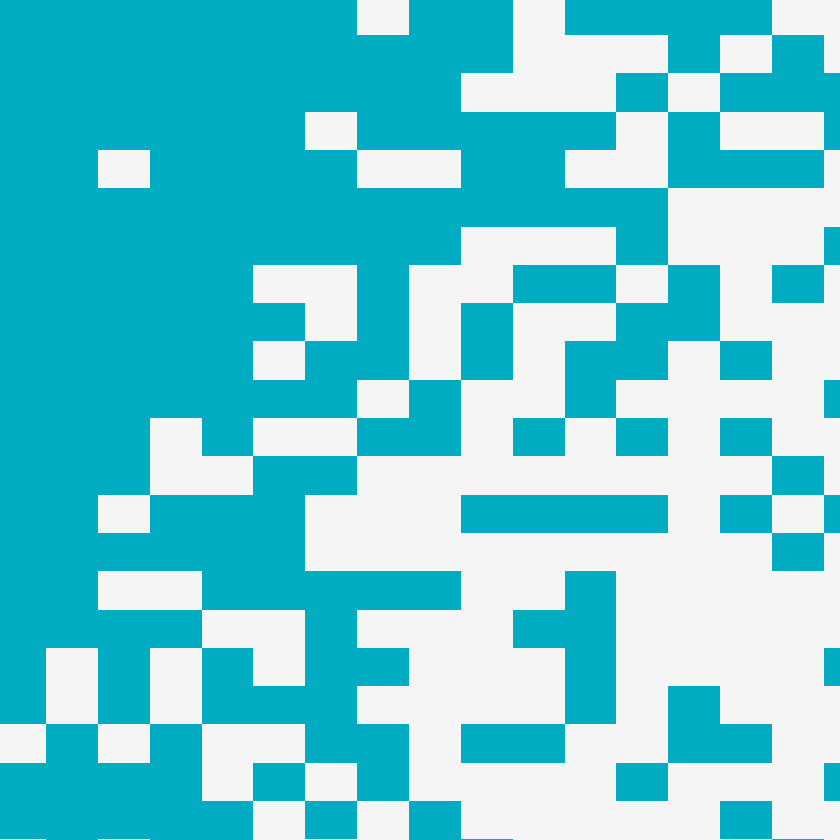

In [42]:
p

In [ ]:
pdf("TCMA_cancer_gene_mutation_01_cancer_gene_sort.pdf", width = 35, height = 15)
draw(p)
dev.off()

pdf 
  2

In [ ]:
## 2

In [ ]:
library(dplyr)
library(tidyr)
library(readr)
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(colorspace)

In [ ]:
cohort= read.csv('data/256sample_mutation_paired_clinical_filter_adjust.csv',sep=",",quote="\"",header=T)

In [ ]:
gene_counts_tumor <- cohort_selected %>%
  filter(class == "tumor") %>%        
  group_by(Gene.MT_ensGene) %>%     
  summarise(Counts = n(), .groups = "drop") %>% 
  arrange(desc(Counts))             


In [ ]:
data <- read.csv('TCMA_cancer_gene_counts.csv',sep=",",quote="",header=T)

In [ ]:
sample_count=read.csv('TCMA_cancer_sample_counts.csv',sep=",",quote="",header=T)

In [ ]:
data_grouped <- data %>%
  group_by(Cancer_Type, Gene) %>%
  summarise(count = sum(Count)) %>%
  ungroup() %>%
  mutate(cancer_count = table(Cancer_Type)[Cancer_Type],
         gene_count = table(Gene)[Gene]) %>%
  arrange(desc(gene_count), desc(cancer_count))

In [ ]:
library(tidyr)
library(dplyr)
df=data_grouped
mat <- df |>
  group_by(Cancer_Type, Gene) |>
  summarise(count = sum(count), .groups = "drop") |>
  tidyr::pivot_wider(names_from = Gene,
                     values_from = count,
                     values_fill = 0) |>
  arrange(Cancer_Type)
write.csv(mat, "TCMA_cancer_gene_totalCounts_matrix.csv", row.names = FALSE)

In [ ]:
sample_count <- sample_count %>%
  mutate(Cancer_Type_label = paste0(Cancer_Type, " (n=", sample_count, ")"))
data_grouped1 <- merge(data_grouped,sample_count[,c(1,3)],by.x=1,by.y=1)

In [ ]:
colors <- qualitative_hcl(37, palette = "Dark 3")

data_grouped1_sorted$Cancer_Type_label <- factor(
  data_grouped1_sorted$Cancer_Type_label,
  levels = rev(unique(data_grouped1_sorted$Cancer_Type_label))  
)

data_grouped1_sorted$Gene <- factor(
  data_grouped1_sorted$Gene,
  levels = data_grouped1_sorted %>%
    group_by(Gene) %>%
    summarise(gene_count = max(gene_count)) %>%
    arrange(desc(gene_count)) %>%
    pull(Gene)
)

p <- ggplot(data_grouped1_sorted, aes(x = Gene, y = Cancer_Type_label, size = count, color = Cancer_Type_label)) +
  geom_point(alpha = 0.7) +
  scale_size_continuous(range = c(1, 15)) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
    axis.text.y = element_text(size = 14),
    legend.position = "none",
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    axis.line = element_line(color = "black", size = 0.5)  
  ) +
  labs(x = "Gene", y = "Cancer Type") +
  scale_color_manual(values = colors)